# 메이플스토리 챌린저스 서버 레벨 260+ 유저 데이터 추출

## 목표
- 챌린저스 서버에서 레벨 260 이상인 모든 유저의 정보를 추출
- JSON 파일로 완전한 데이터 저장
- 상세한 통계 분석 제공

## 주의사항
- 넥슨 오픈 API 사용 (API 키 필요)
- 실행 시간이 오래 걸릴 수 있음 (완전한 데이터 추출을 위해)
- API 호출 제한을 준수하기 위해 적절한 딜레이 포함

## 1. 라이브러리 임포트 및 설정

In [18]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from typing import List, Dict, Optional
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
# Google Colab 영어 전용 설정
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

korean_support = False  # 영어 전용
print("🔤 영어 전용 모드로 설정되었습니다.")

print("✅ 라이브러리 임포트 완료")

🔤 영어 전용 모드로 설정되었습니다.
✅ 라이브러리 임포트 완료


## 2. API 설정 및 클래스 정의

In [33]:
class MapleStoryChallengersAnalyzer:
    """
    메이플스토리 챌린저스 서버 데이터 분석기
    """

    def __init__(self, api_key: str):
        self.api_key = api_key
        self.base_url = "https://open.api.nexon.com"
        self.headers = {
            "x-nxopen-api-key": api_key,
            "Content-Type": "application/json"
        }
        self.world_name = "챌린저스4"
        self.min_level = 260
        self.all_users_data = []

    def get_yesterday_date(self) -> str:
        """어제 날짜 반환 (YYYY-MM-DD)"""
        yesterday = datetime.now() - timedelta(days=1)
        return yesterday.strftime("%Y-%m-%d")

    def get_ranking_page(self, page: int) -> Optional[Dict]:
        """
        특정 페이지의 랭킹 데이터 조회

        Args:
            page (int): 페이지 번호

        Returns:
            Dict: API 응답 데이터 또는 None
        """
        url = f"{self.base_url}/maplestory/v1/ranking/overall"

        params = {
            "date": self.get_yesterday_date(),
            "world_name": self.world_name,
            "page": page
        }

        try:
            response = requests.get(url, headers=self.headers, params=params)
            response.raise_for_status()
            return response.json()
        except requests.RequestException as e:
            print(f"❌ 페이지 {page} 조회 실패: {e}")
            return None

    def extract_all_users_above_level(self, delay_seconds: float = 0.2) -> List[Dict]:
        """
        레벨 260 이상의 모든 유저 데이터 추출

        Args:
            delay_seconds (float): API 호출 간 딜레이 (초)

        Returns:
            List[Dict]: 모든 유저 데이터
        """
        print(f"🚀 {self.world_name} 서버에서 레벨 {self.min_level}+ 유저 데이터 추출을 시작합니다...")
        print(f"📅 기준일: {self.get_yesterday_date()}")
        print(f"⏱️  API 호출 간격: {delay_seconds}초")

        page = 1
        total_users = 0
        total_api_calls = 0

        while True:
            print(f"📄 페이지 {page} 조회 중... (현재 발견: {total_users}명)")

            # API 호출
            ranking_data = self.get_ranking_page(page)
            total_api_calls += 1

            if not ranking_data or 'ranking' not in ranking_data:
                print(f"⚠️ 페이지 {page}에서 데이터를 가져올 수 없습니다.")
                break

            current_page_users = ranking_data['ranking']

            # 빈 페이지 체크
            if not current_page_users:
                print(f"📋 페이지 {page}가 비어있습니다. 조회를 종료합니다.")
                break

            # 레벨 필터링
            page_filtered_users = []
            below_level_found = False

            for user in current_page_users:
                user_level = user.get('character_level', 0)

                if user_level >= self.min_level:
                    page_filtered_users.append(user)
                    # 추가 정보 기록
                    user['extracted_at'] = datetime.now().isoformat()
                    user['page_number'] = page
                else:
                    below_level_found = True
                    print(f"✅ 레벨 {self.min_level} 미만 유저 발견 (레벨 {user_level}). 추출 완료!")
                    break

            # 현재 페이지에서 찾은 유저들 추가
            self.all_users_data.extend(page_filtered_users)
            total_users += len(page_filtered_users)

            print(f"   ➤ 이번 페이지에서 {len(page_filtered_users)}명 발견")

            # 레벨 미만 유저가 발견되면 종료
            if below_level_found:
                break

            # 다음 페이지로
            page += 1

            # API 호출 제한 준수를 위한 딜레이
            time.sleep(delay_seconds)

        print(f"\n🎉 추출 완료!")
        print(f"📊 총 발견 유저: {total_users}명")
        print(f"📞 총 API 호출: {total_api_calls}회")
        print(f"⏱️  소요 시간: 약 {total_api_calls * delay_seconds:.1f}초")

        return self.all_users_data

    def save_to_json(self, filename: Optional[str] = None) -> str:
        """
        데이터를 JSON 파일로 저장

        Args:
            filename (str): 파일명 (None이면 자동 생성)

        Returns:
            str: 저장된 파일명
        """
        if not filename:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"challengers_level{self.min_level}_above_{timestamp}.json"

        # 저장할 데이터 구성
        output_data = {
            "metadata": {
                "extracted_at": datetime.now().isoformat(),
                "world_name": self.world_name,
                "min_level": self.min_level,
                "data_date": self.get_yesterday_date(),
                "total_users": len(self.all_users_data),
                "api_version": "v1"
            },
            "users": self.all_users_data
        }

        try:
            with open(filename, 'w', encoding='utf-8') as f:
                json.dump(output_data, f, ensure_ascii=False, indent=2)
            print(f"✅ 데이터가 '{filename}' 파일로 저장되었습니다.")
            return filename
        except Exception as e:
            print(f"❌ 파일 저장 실패: {e}")
            return ""

# API 키 설정
API_KEY = "live_24e7ede45f168bf4b039b07677f76aa58894c93ab408f4bd96ca1e60aaf6932cefe8d04e6d233bd35cf2fabdeb93fb0d"

# 분석기 인스턴스 생성
analyzer = MapleStoryChallengersAnalyzer(API_KEY)

print("✅ 메이플스토리 챌린저스2 분석기 준비 완료")
print(f"🌍 대상 서버: {analyzer.world_name}")
print(f"📈 최소 레벨: {analyzer.min_level}")

✅ 메이플스토리 챌린저스2 분석기 준비 완료
🌍 대상 서버: 챌린저스4
📈 최소 레벨: 260


## 3. 데이터 추출 실행

⚠️ **주의**: 이 셀은 실행 시간이 오래 걸릴 수 있습니다. 챌린저스 서버의 모든 260+ 레벨 유저를 완전히 추출합니다.

In [34]:
# 데이터 추출 시작
# delay_seconds를 조정하여 API 호출 속도 조절 가능 (0.1~0.5초 권장)
users_data = analyzer.extract_all_users_above_level(delay_seconds=0.15)

print(f"\n📋 추출 완료 요약:")
print(f"총 유저 수: {len(users_data)}명")
if users_data:
    levels = [user.get('character_level', 0) for user in users_data]
    print(f"최고 레벨: {max(levels)}")
    print(f"최저 레벨: {min(levels)}")
    print(f"평균 레벨: {np.mean(levels):.1f}")

🚀 챌린저스4 서버에서 레벨 260+ 유저 데이터 추출을 시작합니다...
📅 기준일: 2025-07-21
⏱️  API 호출 간격: 0.15초
📄 페이지 1 조회 중... (현재 발견: 0명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 2 조회 중... (현재 발견: 200명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 3 조회 중... (현재 발견: 400명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 4 조회 중... (현재 발견: 600명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 5 조회 중... (현재 발견: 800명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 6 조회 중... (현재 발견: 1000명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 7 조회 중... (현재 발견: 1200명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 8 조회 중... (현재 발견: 1400명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 9 조회 중... (현재 발견: 1600명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 10 조회 중... (현재 발견: 1800명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 11 조회 중... (현재 발견: 2000명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 12 조회 중... (현재 발견: 2200명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 13 조회 중... (현재 발견: 2400명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 14 조회 중... (현재 발견: 2600명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 15 조회 중... (현재 발견: 2800명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 16 조회 중... (현재 발견: 3000명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 17 조회 중... (현재 발견: 3200명)
   ➤ 이번 페이지에서 200명 발견
📄 페이지 18 조회 중... (

## 4. JSON 파일 저장

In [35]:
# JSON 파일로 저장
saved_filename = analyzer.save_to_json()

if saved_filename:
    # 파일 크기 확인
    import os
    file_size = os.path.getsize(saved_filename)
    print(f"📄 파일 크기: {file_size / 1024:.1f} KB")

    # 저장된 데이터 샘플 확인
    with open(saved_filename, 'r', encoding='utf-8') as f:
        sample_data = json.load(f)

    print(f"\n📊 저장된 데이터 메타정보:")
    for key, value in sample_data['metadata'].items():
        print(f"  {key}: {value}")

✅ 데이터가 'challengers_level260_above_20250722_003827.json' 파일로 저장되었습니다.
📄 파일 크기: 50652.5 KB

📊 저장된 데이터 메타정보:
  extracted_at: 2025-07-22T00:38:27.498219
  world_name: 챌린저스4
  min_level: 260
  data_date: 2025-07-21
  total_users: 124448
  api_version: v1


## 5. 기본 데이터 분석

In [36]:
# 데이터프레임으로 변환
if users_data:
    df = pd.DataFrame(users_data)

    print("📊 기본 데이터 정보:")
    print(f"데이터 수: {len(df)}개")
    print(f"컬럼 수: {len(df.columns)}개")
    print(f"\n컬럼 목록:")
    for col in df.columns:
        print(f"  - {col}")

    print(f"\n📈 레벨 통계:")
    print(df['character_level'].describe())

    print(f"\n⚔️ 직업별 분포:")
    job_counts = df['class_name'].value_counts()
    print(job_counts.head(10))

    print(f"\n🏆 상위 10명:")
    top_10 = df.nlargest(10, ['character_level', 'character_exp'])
    for idx, user in top_10.iterrows():
        print(f"{user['ranking']}위: {user['character_name']} (레벨 {user['character_level']}, {user['class_name']})")
else:
    print("❌ 분석할 데이터가 없습니다.")

📊 기본 데이터 정보:
데이터 수: 124448개
컬럼 수: 12개

컬럼 목록:
  - date
  - world_name
  - ranking
  - character_name
  - character_level
  - character_exp
  - class_name
  - sub_class_name
  - character_popularity
  - character_guildname
  - extracted_at
  - page_number

📈 레벨 통계:
count    124448.000000
mean        270.737023
std           5.439130
min         260.000000
25%         266.000000
50%         272.000000
75%         275.000000
max         286.000000
Name: character_level, dtype: float64

⚔️ 직업별 분포:
class_name
렌        95835
레지스탕스     2968
궁수        2902
일리움       2823
전사        2655
도적        2235
마법사       2198
기사단       1992
해적        1798
칼리        1065
Name: count, dtype: int64

🏆 상위 10명:
1위: 매화잔해 (레벨 286, 렌)
2위: 니망 (레벨 285, 렌)
3위: 손만잡고잘렌 (레벨 285, 렌)
4위: 뽀식 (레벨 285, 렌)
5위: 작은방 (레벨 285, 렌)
6위: 외걸1호 (레벨 285, 렌)
7위: 패유렌 (레벨 284, 렌)
8위: 감초렌 (레벨 284, 렌)
9위: 갱플 (레벨 284, 렌)
10위: 칼라빈카 (레벨 284, 렌)


## 6. 상세 통계 분석 및 시각화

📊 그래프 모드: 영어


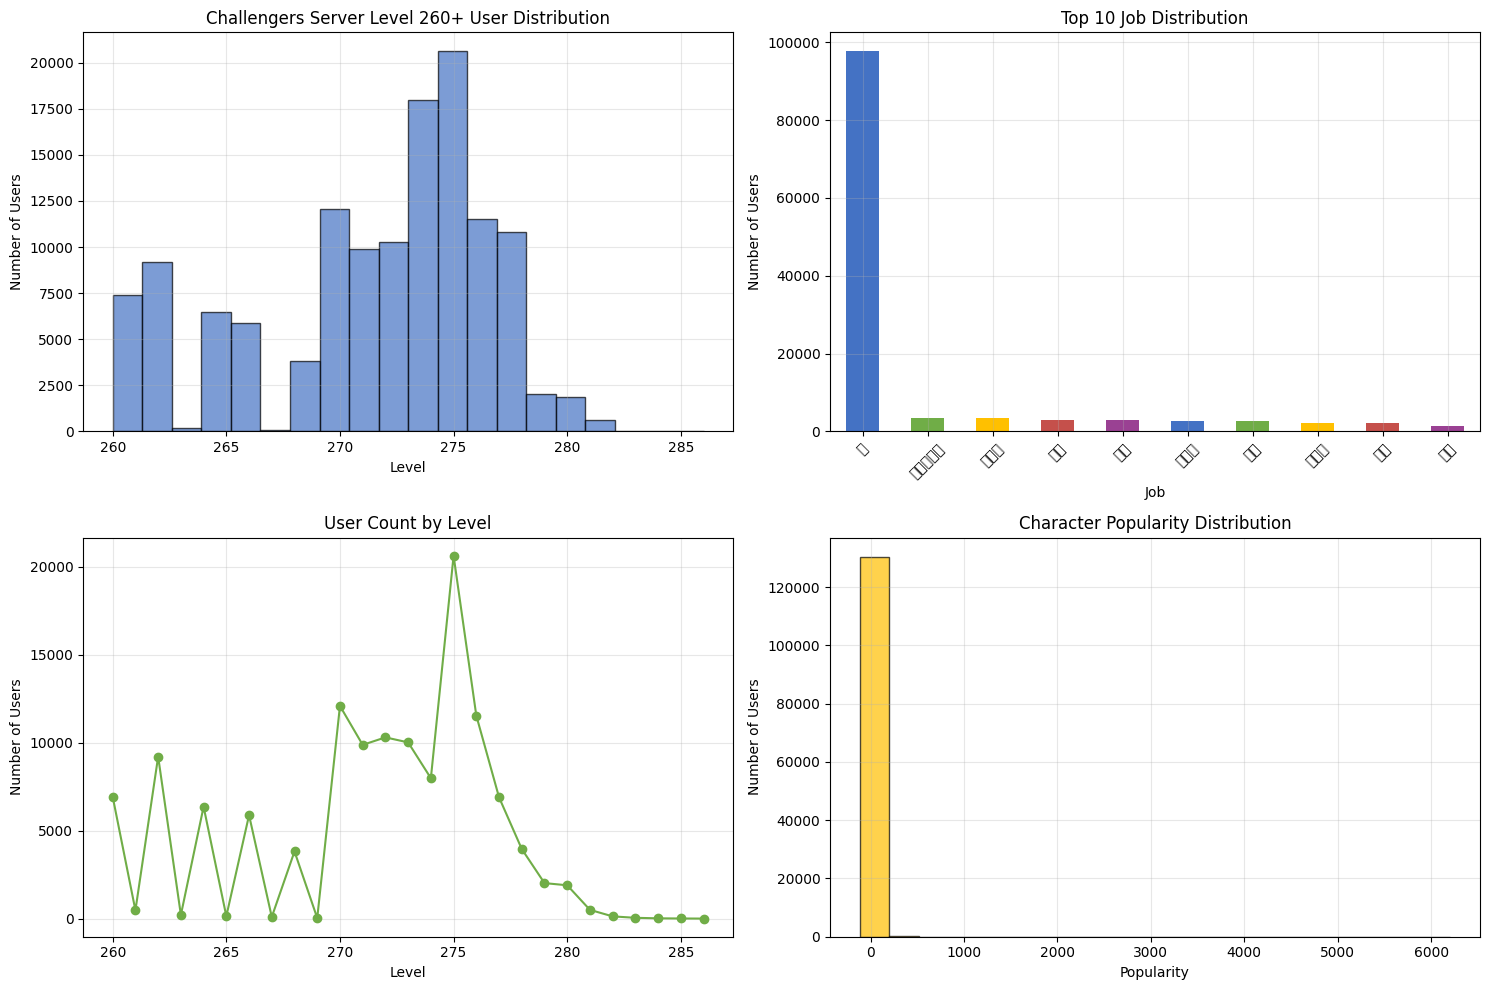


📊 Challengers Server Analysis


In [31]:
if users_data and len(users_data) > 0:
    # Google Colab용 폰트 설정 (간단 버전)
    import warnings
    warnings.filterwarnings('ignore')  # 폰트 경고 숨기기

    # 이미 설정된 폰트 사용 (위에서 실행한 코드의 결과)
    # korean_support 변수가 이미 정의되어 있어야 함

    if 'korean_support' not in globals():
        # 변수가 없으면 영어 모드로 설정
        korean_support = False
        plt.rcParams['font.family'] = 'DejaVu Sans'
        plt.rcParams['axes.unicode_minus'] = False
        print("⚠️ 영어 모드로 자동 설정됨")

    print(f"📊 그래프 모드: {'한글' if korean_support else '영어'}")

    # 그래프 크기 설정
    plt.figure(figsize=(15, 10))

    # 색상 설정
    colors = ['#4472C4', '#70AD47', '#FFC000', '#C5504B', '#9A4193']

    # 1. 레벨 분포 히스토그램
    plt.subplot(2, 2, 1)
    plt.hist(df['character_level'], bins=20, edgecolor='black', alpha=0.7, color=colors[0])

    if korean_support:
        plt.title(f'챌린저스 서버 레벨 {analyzer.min_level}+ 유저 레벨 분포', fontsize=12)
        plt.xlabel('레벨')
        plt.ylabel('유저 수')
    else:
        plt.title(f'Challengers Server Level {analyzer.min_level}+ User Distribution', fontsize=12)
        plt.xlabel('Level')
        plt.ylabel('Number of Users')

    plt.grid(True, alpha=0.3)

    # 2. 직업별 분포
    plt.subplot(2, 2, 2)
    top_jobs = df['class_name'].value_counts().head(10)
    top_jobs.plot(kind='bar', color=colors[:len(top_jobs)])

    if korean_support:
        plt.title('상위 10개 직업 분포', fontsize=12)
        plt.xlabel('직업')
        plt.ylabel('유저 수')
    else:
        plt.title('Top 10 Job Distribution', fontsize=12)
        plt.xlabel('Job')
        plt.ylabel('Number of Users')

    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

    # 3. 레벨별 유저 수
    plt.subplot(2, 2, 3)
    level_counts = df['character_level'].value_counts().sort_index()
    level_counts.plot(kind='line', marker='o', color=colors[1])

    if korean_support:
        plt.title('레벨별 유저 수 추이', fontsize=12)
        plt.xlabel('레벨')
        plt.ylabel('유저 수')
    else:
        plt.title('User Count by Level', fontsize=12)
        plt.xlabel('Level')
        plt.ylabel('Number of Users')

    plt.grid(True, alpha=0.3)

    # 4. 인기도/경험치 분포
    plt.subplot(2, 2, 4)
    if 'character_popularity' in df.columns:
        plt.hist(df['character_popularity'], bins=20, edgecolor='black', alpha=0.7, color=colors[2])
        title = '캐릭터 인기도 분포' if korean_support else 'Character Popularity Distribution'
        xlabel = '인기도' if korean_support else 'Popularity'
    else:
        exp_data = df['character_exp'].astype(float) / 1e12
        plt.hist(exp_data, bins=20, edgecolor='black', alpha=0.7, color=colors[2])
        title = '경험치 분포 (조 단위)' if korean_support else 'Experience Distribution (Trillion)'
        xlabel = '경험치 (조)' if korean_support else 'Experience (Trillion)'

    plt.title(title, fontsize=12)
    plt.xlabel(xlabel)
    plt.ylabel('유저 수' if korean_support else 'Number of Users')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # 나머지 통계 출력 코드는 동일...
    print("\n" + "="*60)
    print("📊 챌린저스 서버 분석 결과" if korean_support else "📊 Challengers Server Analysis")
    print("="*60)

else:
    print("❌ 시각화할 데이터가 없습니다.")

## 7. 최종 요약 및 CSV 저장

In [37]:
if users_data:
    # CSV 파일로도 저장
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    csv_filename = f"challengers_level260_above_{timestamp}.csv"

    try:
        df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"✅ CSV 파일로도 저장됨: {csv_filename}")
    except Exception as e:
        print(f"❌ CSV 저장 실패: {e}")

    # 최종 요약
    print(f"\n" + "="*60)
    print(f"🎯 최종 추출 완료 요약")
    print(f"="*60)
    print(f"📅 데이터 기준일: {analyzer.get_yesterday_date()}")
    print(f"🌍 대상 서버: {analyzer.world_name}")
    print(f"📈 최소 레벨: {analyzer.min_level}")
    print(f"👥 총 추출 유저: {len(users_data)}명")
    print(f"📄 JSON 파일: {saved_filename}")
    print(f"📊 CSV 파일: {csv_filename}")

    levels = df['character_level']
    print(f"\n📊 레벨 통계:")
    print(f"  최고 레벨: {levels.max()}")
    print(f"  최저 레벨: {levels.min()}")
    print(f"  평균 레벨: {levels.mean():.1f}")
    print(f"  중앙값: {levels.median():.1f}")
    print(f"  표준편차: {levels.std():.1f}")

    print(f"\n🏆 최고 레벨 캐릭터들:")
    max_level = levels.max()
    top_characters = df[df['character_level'] == max_level]
    for _, char in top_characters.iterrows():
        exp_formatted = f"{char['character_exp']:,}" if 'character_exp' in char else "N/A"
        print(f"  {char['character_name']} (레벨 {char['character_level']}, {char['class_name']}, 경험치: {exp_formatted})")

    print(f"\n✅ 모든 작업이 완료되었습니다!")
else:
    print("❌ 처리할 데이터가 없습니다.")

✅ CSV 파일로도 저장됨: challengers_level260_above_20250722_003921.csv

🎯 최종 추출 완료 요약
📅 데이터 기준일: 2025-07-21
🌍 대상 서버: 챌린저스4
📈 최소 레벨: 260
👥 총 추출 유저: 124448명
📄 JSON 파일: challengers_level260_above_20250722_003827.json
📊 CSV 파일: challengers_level260_above_20250722_003921.csv

📊 레벨 통계:
  최고 레벨: 286
  최저 레벨: 260
  평균 레벨: 270.7
  중앙값: 272.0
  표준편차: 5.4

🏆 최고 레벨 캐릭터들:
  매화잔해 (레벨 286, 렌, 경험치: 59,145,707,185,750)

✅ 모든 작업이 완료되었습니다!
